## First Steps with TensorFlow

### Contant tensors and variables

In [2]:
import numpy as np
import tensorflow as tf

In [3]:
# np ndarrays are assignable
x = np.ones(shape=(2, 2))
x[0, 0] = 0.

print(f"{x = }")

x = array([[0., 1.],
       [1., 1.]])


In [5]:
# tf tensors are not
x = tf.ones(shape=(2, 2))
x[0, 0] = 0.


TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

In [6]:
# use variables instead to manage state
v = tf.Variable(initial_value=tf.ones(shape=(2, 2)))
print(f"{v = }")

v = <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[1., 1.],
       [1., 1.]], dtype=float32)>


In [7]:
v.assign(tf.zeros(shape=(2, 2)))
print(f"{v = }")

v = <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[0., 0.],
       [0., 0.]], dtype=float32)>


In [8]:
# also works in subset of coefficients
v[0, 0].assign(3.)
print(f"{v = }")

v = <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[3., 0.],
       [0., 0.]], dtype=float32)>


you also have `assign_add()` and `addign_sub()`

### Tensorflow operations

In [9]:
a = tf.ones((2, 2))
print(f"{a = }")

b = tf.square(a)
print(f"{b = }")

c = tf.sqrt(a)
print(f"{c = }")

d = b + c
print(f"{d = }")

e = tf.matmul(a, b)
print(f"{e = }")

e *= d
print(f"{e = }")


a = <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [1., 1.]], dtype=float32)>
b = <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [1., 1.]], dtype=float32)>
c = <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [1., 1.]], dtype=float32)>
d = <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 2.],
       [2., 2.]], dtype=float32)>
e = <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 2.],
       [2., 2.]], dtype=float32)>
e = <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[4., 4.],
       [4., 4.]], dtype=float32)>


### A second look at the GradientTape API

In [10]:
input_var = tf.Variable(initial_value=3.)

with tf.GradientTape() as tape:
    result = tf.square(input_var)

gradient = tape.gradient(result, input_var)

print(f"{gradient = }")

gradient = <tf.Tensor: shape=(), dtype=float32, numpy=6.0>


In [11]:
# only trainable variables are tracked by default, but you can specify any arbitrary tensor
input_const = tf.constant(3.)

with tf.GradientTape() as tape:
    tape.watch(input_const)
    result = tf.square(input_const)

gradient = tape.gradient(result, input_const)

print(f"{gradient = }")

gradient = <tf.Tensor: shape=(), dtype=float32, numpy=6.0>


In [12]:
# you can nest to calculate higher-order derivative
time = tf.Variable(0.)

with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        position = 4.9 * time ** 2
    
    speed = inner_tape.gradient(position, time)
acceleration = outer_tape.gradient(speed, time)

print(f"{speed = }")
print(f"{acceleration = }")

speed = <tf.Tensor: shape=(), dtype=float32, numpy=0.0>
acceleration = <tf.Tensor: shape=(), dtype=float32, numpy=9.8>


### End-to-end example: A linear classifier in pure TensorFlow

#### generating 2 classes or ranfom points in 2D

In [13]:
samples_per_class = 1_000

negative_samples = np.random.multivariate_normal(mean=[0, 3], cov=[[1, .5], [.5, 1]], size=samples_per_class)
positive_samples = np.random.multivariate_normal(mean=[3, 0], cov=[[1, .5], [.5, 1]], size=samples_per_class)

inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)
print(f"{inputs.shape = }")

targets = np.vstack((
    np.zeros((samples_per_class, 1), dtype="float32"),
    np.ones((samples_per_class, 1), dtype="float32"),
))

print(f"{targets.shape = }")

inputs.shape = (2000, 2)
targets.shape = (2000, 1)


In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

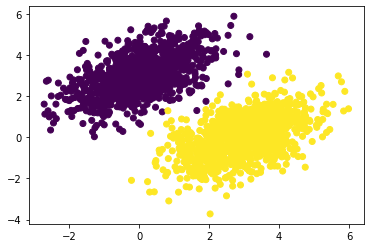

In [15]:
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

In [16]:
# lets train a linear classifier y = W @ inputs + b
input_dim = 2
output_dim = 1


W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim, )))

def model(inputs):
    return tf.matmul(inputs, W) + b

In [17]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

In [18]:
LR = .1

def train_step(inputs, targets):
    """"""
    # forward pass
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(targets, predictions)

    # backwards
    grad_wrt_W, grad_wrt_b = tape.gradient(loss, [W, b])
    
    # step
    W.assign_sub(LR* grad_wrt_W)
    b.assign_sub(LR* grad_wrt_b)

    return loss

    

for simplicity, and since we have a small ds, we'll do GD instead og SGD

In [19]:
for step in range(40):
    loss = train_step(inputs, targets)
    print(f"{step = }: {loss = }")

step = 0: loss = <tf.Tensor: shape=(), dtype=float32, numpy=4.219779>
step = 1: loss = <tf.Tensor: shape=(), dtype=float32, numpy=0.68534774>
step = 2: loss = <tf.Tensor: shape=(), dtype=float32, numpy=0.22008789>
step = 3: loss = <tf.Tensor: shape=(), dtype=float32, numpy=0.14508058>
step = 4: loss = <tf.Tensor: shape=(), dtype=float32, numpy=0.12627606>
step = 5: loss = <tf.Tensor: shape=(), dtype=float32, numpy=0.11617005>
step = 6: loss = <tf.Tensor: shape=(), dtype=float32, numpy=0.10795253>
step = 7: loss = <tf.Tensor: shape=(), dtype=float32, numpy=0.100598894>
step = 8: loss = <tf.Tensor: shape=(), dtype=float32, numpy=0.0939113>
step = 9: loss = <tf.Tensor: shape=(), dtype=float32, numpy=0.087813936>
step = 10: loss = <tf.Tensor: shape=(), dtype=float32, numpy=0.0822525>
step = 11: loss = <tf.Tensor: shape=(), dtype=float32, numpy=0.07717956>
step = 12: loss = <tf.Tensor: shape=(), dtype=float32, numpy=0.07255218>
step = 13: loss = <tf.Tensor: shape=(), dtype=float32, numpy=0.

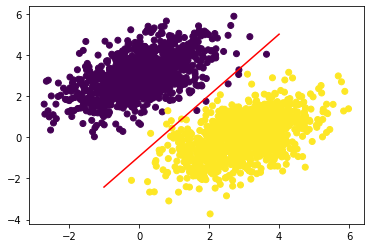

In [33]:
plt.figure()

# plot data
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])

# plot learned classifier
x = np.linspace(-1, 4, 100)
y = - W[0] / W[1] * x + (.5 - b) / W[1]

plt.plot(x, y, '-r')
plt.show()

## The base layer class in Keras

In [22]:
tf.keras.layers.Layer.add_weight

<function keras.engine.base_layer.Layer.add_weight(self, name=None, shape=None, dtype=None, initializer=None, regularizer=None, trainable=None, constraint=None, use_resource=None, synchronization=<VariableSynchronization.AUTO: 0>, aggregation=<VariableAggregationV2.NONE: 0>, **kwargs)>

In [ ]:
# dense layer implementation as keras.layers.Layer subclass

class SimpleDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None):
        self.units = units
        self.activation = activation

    def build(self, input_shape): # input_shape: shape of first input seen by layer
        input_dim = input_shape[-1]

        self.W = self.add_weights(shape=(input_dim, self.units), initializer='random_uniform')


    def call(self, inputs):
        pass
# init params (units, activation=None)

In [ ]:
# dense layer implementation as keras.layers.Layer subclass

class SimpleDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None):
        self.units = units
        self.activation = activation

    def build(self, input_shape): # input_shape: shape of first input seen by layer
        input_dim = input_shape[-1]

        self.W = self.add_weights(shape=(input_dim, self.units), initializer='random_uniform')


    def call(self, inputs):
        pass
# init params (units, activation=None)

In [31]:
# dense layer implementation as keras.layers.Layer subclass

class SimpleDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape): # input_shape: shape of first input seen by layer
        input_dim = input_shape[-1]

        self.W = self.add_weight(shape=(input_dim, self.units), initializer='random_normal')
        self.b = self.add_weight(shape=(self.units, ), initializer='zeros')


    def call(self, inputs):
        y = tf.matmul(inputs, self.W) + self.b

        if self.activation is not None:
            y = self.activation(y)

        return y


In [32]:
simple_dense = SimpleDense(32, activation=tf.keras.activations.softmax)

random_input = tf.random.uniform(shape=(4, 64))
y = simple_dense(random_input)

assert y.shape == (4, 32)

In [34]:
## Classify the 2D points with keras

In [36]:
from tensorflow import keras

In [51]:
model = keras.models.Sequential([SimpleDense(1)])

In [52]:
model.compile(
    optimizer='rmsprop', 
    loss='binary_crossentropy',
    metrics=['accuracy'], 
)

In [53]:
indices_permutations = np.random.permutation(len(targets))

shuffled_inputs = inputs[indices_permutations]
shuffled_targets = targets[indices_permutations]

In [54]:
n_validation_samples = int(.3 * len(targets))

train_inputs = shuffled_inputs[n_validation_samples:]
train_targets = shuffled_targets[n_validation_samples:]
valid_inputs = shuffled_inputs[:n_validation_samples]
valid_targets = shuffled_targets[:n_validation_samples]

assert len(valid_targets) == n_validation_samples

In [55]:
history = model.fit(
    train_inputs,
    train_targets,
    epochs=5,
    batch_size=16,
    validation_data=(valid_inputs, valid_targets),
)

Epoch 1/5
88/88 [==============================] - 4s 29ms/step - loss: 7.7664 - accuracy: 0.4857 - val_loss: 4.8065 - val_accuracy: 0.5333
Epoch 2/5
88/88 [==============================] - 1s 11ms/step - loss: 1.8895 - accuracy: 0.4857 - val_loss: 0.8524 - val_accuracy: 0.5333
Epoch 3/5
88/88 [==============================] - 1s 11ms/step - loss: 0.6604 - accuracy: 0.5121 - val_loss: 0.3922 - val_accuracy: 0.6867
Epoch 4/5
88/88 [==============================] - 1s 12ms/step - loss: 0.2885 - accuracy: 0.8529 - val_loss: 0.1506 - val_accuracy: 0.9783
Epoch 5/5
88/88 [==============================] - 1s 11ms/step - loss: 0.1018 - accuracy: 0.9821 - val_loss: 0.0516 - val_accuracy: 0.9950


In [56]:
history.history

{'loss': [7.766387939453125,
  1.8895339965820312,
  0.66041499376297,
  0.2884885370731354,
  0.10178489983081818],
 'accuracy': [0.48571428656578064,
  0.48571428656578064,
  0.5121428370475769,
  0.8528571724891663,
  0.9821428656578064],
 'val_loss': [4.80648136138916,
  0.8523696660995483,
  0.3921537399291992,
  0.15060272812843323,
  0.05156012997031212],
 'val_accuracy': [0.5333333611488342,
  0.5333333611488342,
  0.6866666674613953,
  0.9783333539962769,
  0.9950000047683716]}

In [57]:
loss_and_metrics = model.evaluate(valid_inputs, valid_targets, batch_size=128)

5/5 [==============================] - 0s 10ms/step - loss: 0.0516 - accuracy: 0.9950


In [58]:
loss_and_metrics

[0.05156012997031212, 0.9950000047683716]

### inference 

In [59]:
# predict on entire ds
predictions = model(valid_inputs)

In [60]:
# if the ds was too big to fit in memory:
predictions = model.predict(valid_inputs, batch_size=128)